**Written by** : Lucrece (Jahyun) Shin

**Final Edit Date** : 12/22/2021

**Contact** : lucrece.shin@mail.utoronto.ca
# 1 Import Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time, os
from PIL import Image, ImageFile
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.utils import model_zoo

try:
  from torch.hub import load_state_dict_from_url
except ImportError:
  from torch.utils.model_zoo import load_url as load_state_dict_from_url

ImageFile.LOAD_TRUNCATED_IMAGES = True
use_cuda = torch.cuda.is_available()

In [5]:
# Import your Google drive if necessary
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 2 Define Multi-label Dataset
To use multi-label dataset as discussed in [my blog post](https://medium.com/mlearning-ai/ch-6-optimizing-data-for-flexible-and-robust-image-recognition-23f4dcce3af7#f4d3), you must organize your folders in the following way:

* [class a]+[class b] for images that contain both class a and b
* [class a] for image that contain only class a

For example, I originlly had 3 classes (gun, knife, benign) and made the following folders:
* gun
* gun+benign
* knife
* knife+benign
* gun+knife
* benign

Here I am only considering images that contain **at most 2 classes**. Please adjust code for a situation where you must consider image containing more than 2 classes.

In [6]:
class MultiLabelWebDataset(Dataset):
  def __init__(self, root_dir, classes, transform=None, soft_label_class_name=None, soft_label=0.5):
    # soft_label_class_name : name of the class that is given a soft label < 1
    self.root_dir = root_dir
    self.transform = transform
    self.classes = classes
    self.class_to_idx = {c:i for i, c in enumerate(self.classes)}
    self.soft_label_class_name = soft_label_class_name
    self.soft_label = soft_label  
    self.data = self.make_dataset()                                        
                                                      
  def __len__(self):
    return len(self.make_dataset())

  def make_dataset(self):
    instances = []
    for target_class in os.listdir(self.root_dir):      
      target_dir = os.path.join(self.root_dir, target_class)
      # split up the class names by "+" sign
      class_names = target_class.split("+") # list of length 1 or 2
      if not os.path.isdir(target_dir):
        continue
      for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
        for fname in sorted(fnames):  # for each image
          label = [0]*len(self.classes)
          path = os.path.join(self.root_dir, target_class, fname)

          if len(class_names)==1:  # images that contain only one class
            single_cls = class_names[0]
            if single_cls==self.soft_label_class_name:
              label[self.class_to_idx[single_cls]] = self.soft_label
            else:
              label[self.class_to_idx[single_cls]] = 1.

          elif len(class_names)==2:  # images that contain two classes
            for cls in class_names:
              if cls==self.soft_label_class_name:
                label[self.class_to_idx[cls]] = self.soft_label      
              else:
                label[self.class_to_idx[cls]] = 1.
          item = path, label
          instances.append(item)
    return instances

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    path, target = self.data[idx]
    image = Image.open(path).convert('RGB') 
    if self.transform:
      image = self.transform(image)
    return image, torch.tensor(target)

In [7]:
!cp 'gdrive/My Drive/web_3cls+NOcutter.zip' . 
!unzip -qq web_3cls+NOcutter.zip
!rm web_3cls+NOcutter.zip 

## 2.1 Define Source Domain Dataloader

In [8]:
# define image transform
transform_ = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor()])

* `src_root_dir` is a string that contains the name of your **source domain data folder**. It must contain 3 folders named 'train', 'valid', 'test', each containing folders named by class names.
* **soft_label** is a weaker label less than 1. Usually a class is given a label of 1 for a one-hot-encoded label. If a less significant class (if any) is recieving a strong signal from the model (i.e. large recall), you can set a soft label of e.g. 0.5 instead of 1 for that class.

In [10]:
src_root_dir = "web_3cls+NOcutter"## insert your data folder here ##
classes=['benign','gun','knife']
soft_label_class_name="benign"
soft_label=0.5 # weaker label < 1 
train_data_multi_label = MultiLabelWebDataset(src_root_dir + '/train', classes=classes, transform = transform_, soft_label_class_name=soft_label_class_name, soft_label=soft_label)
valid_data_multi_label = MultiLabelWebDataset(src_root_dir + '/valid', classes=classes, transform = transform_, soft_label_class_name=soft_label_class_name, soft_label=soft_label)
test_data_multi_label = MultiLabelWebDataset(src_root_dir + '/test', classes=classes, transform = transform_, soft_label_class_name=soft_label_class_name, soft_label=soft_label)
print("Class2idx: ", train_data_multi_label.class_to_idx)
num_workers = 0
batch_size = 16
dataloaders_multi_label = {}
dataloaders_multi_label['train'] = DataLoader(train_data_multi_label, batch_size=batch_size, num_workers=num_workers, shuffle=True)
dataloaders_multi_label['valid'] = DataLoader(valid_data_multi_label, batch_size=batch_size, num_workers=num_workers, shuffle=True)
dataloaders_multi_label['test'] = DataLoader(test_data_multi_label, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print('Train images :', len(train_data_multi_label), ", # of training batches:", len(dataloaders_multi_label['train']))
print('Valid images :', len(valid_data_multi_label), ", # of valid batches:", len(dataloaders_multi_label['valid']))
print('Test images :', len(test_data_multi_label), ", # of test batches:", len(dataloaders_multi_label['test']))

Class2idx:  {'benign': 0, 'gun': 1, 'knife': 2}
Train images : 5024 , # of training batches: 314
Valid images : 645 , # of valid batches: 41
Test images : 627 , # of test batches: 40


## 2.2 Define Target Domain Dataloader

In [11]:
!cp gdrive/MyDrive/Xray_2classes_cropped.zip .
!unzip -qq Xray_2classes_cropped.zip
!rm Xray_2classes_cropped.zip
!rm Xray_2classes_cropped/knife/Kitchen*
!rm Xray_2classes_cropped/knife/Cutter*
!cp gdrive/My Drive/Xray-3cls_small.zip .
!unzip -qq Xray-3cls_small.zip
!rm Xray-3cls_small.zip 
!rm Xray-3cls_small/knife/Kitchen* 
!rm Xray-3cls_small/knife/Cutter* 

### 2.2.1 Define Target Domain **Train** Dataloader

In [12]:
num_workers = 0
batch_size = 16
tgt_root_dir = 'Xray_2classes_cropped'
xray_dataset = datasets.ImageFolder(tgt_root_dir, transform = transform_) # resize only
xray_dataloader = DataLoader(xray_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print("Classes: ", xray_dataset.class_to_idx)
print("Number of Xray images : {}    Number of Xray batches : {}  (batch size={})".format(len(xray_dataloader.dataset), len(xray_dataloader), batch_size))

Classes:  {'benign_inch': 0, 'gun': 1, 'knife': 2}
Number of Xray images : 1850    Number of Xray batches : 116  (batch size=16)


### 2.2.1 Define Target Domain **Test** Dataloader (smaller)

In [13]:
tgt_root_dir_test = 'Xray-3cls_small'
xray_test_dataset = datasets.ImageFolder(tgt_root_dir_test, transform = transform_) # resize only
xray_test_dataloader = DataLoader(xray_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print("Classes: ", xray_test_dataset.class_to_idx)
print("Number of Xray images : {}    Number of Xray batches : {}  (batch size={})".format(len(xray_test_dataset), len(xray_test_dataloader), batch_size))

Classes:  {'benign_inch': 0, 'gun': 1, 'knife': 2}
Number of Xray images : 450    Number of Xray batches : 29  (batch size=16)


# 2.3 Define Combined Dataloader
This is exclusively used for plotting **t-SNE plots** of source domain and target domain features together. 

In [14]:
!mkdir combined_folder
!mkdir combined_folder/gun_xray
!mkdir combined_folder/knife_xray
!mkdir combined_folder/gun_web
!mkdir combined_folder/knife_web

!cp web_3cls+NOcutter/test/gun/* combined_folder/gun_web/
!cp web_3cls+NOcutter/test/knife/* combined_folder/knife_web/
!cp Xray-3cls_small/gun/* combined_folder/gun_xray/
!cp Xray-3cls_small/knife/* combined_folder/knife_xray/
!mkdir combined_folder/benign_xray
!cp Xray-3cls_small/benign_inch/* combined_folder/benign_xray/

In [15]:
# 3 classes : gun, knife, benign
data_path = 'combined_folder'
num_workers = 0
batch_size = 16

class ImageFolderWithPaths(datasets.ImageFolder):
  ''' dataset containing images as well as image filenames '''
  def __getitem__(self, index):
    original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
    path = self.imgs[index][0]
    tuple_with_path = (original_tuple + (path,))
    return tuple_with_path

combined_dataset = ImageFolderWithPaths(data_path, transform = transform_) 
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print("Classes: ", combined_dataset.classes)
print("Number of Xray images : {}    Number of Xray batches : {}  (batch size={})".format(len(combined_dataset), len(combined_dataloader), batch_size))

Classes:  ['benign_xray', 'gun_web', 'gun_xray', 'knife_web', 'knife_xray']
Number of Xray images : 826    Number of Xray batches : 52  (batch size=16)


# 3 Define Model-related Functions/Classes

## 3.1 Define Function to load ResNet50 pre-trained on Stylized ImageNet 
From paper : [ImageNet-trained CNNs are biased towards texture](https://arxiv.org/abs/1811.12231) and the author's [Github repo](https://github.com/rgeirhos/texture-vs-shape)


In [16]:
def load_model_stylized_imagenet(model_name):

    model_urls = {
            'resnet50_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/6f41d2e86fc60566f78de64ecff35cc61eb6436f/resnet50_train_60_epochs-c8e5653e.pth.tar',
            'resnet50_trained_on_SIN_and_IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_train_45_epochs_combined_IN_SF-2a0d100e.pth.tar',
            'resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar',
            'alexnet_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/0008049cd10f74a944c6d5e90d4639927f8620ae/alexnet_train_60_epochs_lr0.001-b4aa5238.pth.tar',
    }
    if "resnet50" in model_name:
        print("Using the ResNet50 architecture.")
        model = torchvision.models.resnet50(pretrained=False)
        model = torch.nn.DataParallel(model)#.cuda()
        checkpoint = model_zoo.load_url(model_urls[model_name])

    elif "vgg16" in model_name:
        print("Using the VGG-16 architecture.")
        # download model from URL manually and save to desired location
        filepath = "./vgg16_train_60_epochs_lr0.01-6c6fcc9f.pth.tar"
        assert os.path.exists(filepath), "Please download the VGG model yourself from the following link and save it locally: https://drive.google.com/drive/folders/1A0vUWyU6fTuc-xWgwQQeBvzbwi6geYQK (too large to be downloaded automatically like the other models)"
        model = torchvision.models.vgg16(pretrained=False)
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
        checkpoint = torch.load(filepath)

    elif "alexnet" in model_name:
        print("Using the AlexNet architecture.")
        model = torchvision.models.alexnet(pretrained=False)
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
        checkpoint = model_zoo.load_url(model_urls[model_name])
    else:
        raise ValueError("unknown model architecture.")

    model.load_state_dict(checkpoint["state_dict"])
    return model

## 3.2 Define Discriminator Class

In [17]:
class Discriminator(nn.Module):
  def __init__(self, feature_dim):
    super(Discriminator, self).__init__()
    self.restored = False
    self.layer = nn.Sequential(
      nn.Linear(feature_dim, 1024),
      nn.ReLU(),
      nn.Linear(1024, 2048),
      nn.ReLU(),
      nn.Linear(2048, 2),
      nn.LogSoftmax()
    )       
  def forward(self, input):
    out = self.layer(input)
    return out

# 4 Define t-SNE Plotting Function

In [19]:
def scale_to_01_range(x):  
  ''' scale and move the coordinates so they fit [0; 1] range '''
  value_range = (np.max(x) - np.min(x))
  starts_from_zero = x - np.min(x)
  return starts_from_zero / value_range

def plot_tsne(dataloader, # contains data whose encoded features will be plotted
              encoder,    # model to pass data through to extract features 
              plot_imgs=False, # for each feature, plot images if True, plot coloured dots if False
              model_type='resnet50'): # supports one of 'resnet50' or 'vgg16'

  assert model_type in ['resnet50', 'vgg16'], 'model_type must be one of "resnet50" or "vgg16"!'
  encoder = encoder.cuda().eval()
  for i, (data, target, fname) in enumerate(dataloader):
    data = data.cuda() 
    with torch.no_grad():
      if model_type == "resnet50":
        outputs = encoder(data)
        outputs = torch.flatten(outputs, 1)
      elif model_type == "vgg16": 
        outputs = encoder.features(data)
        outputs = encoder.avgpool(outputs)
        outputs = torch.flatten(outputs, 1)
        outputs = encoder.classifier[0](outputs)
        outputs = encoder.classifier[1](outputs)
        outputs = encoder.classifier[2](outputs)
        outputs = encoder.classifier[3](outputs)
        outputs = encoder.classifier[4](outputs)
    outputs = outputs.cpu().numpy()
    features = outputs if i==0 else np.concatenate((features, outputs), axis=0)  
    labels = target if i==0 else np.concatenate((labels, target), axis=0)
    fnames = list(fname) if i==0 else fnames + list(fname) 

  print("# of samples : {} \n feature-dim : {}".format(features.shape[0], features.shape[1]))
  tsne = TSNE(n_components=2).fit_transform(features)

  # extract x and y coordinates representing the positions of the images on T-SNE plot
  fig = plt.figure(figsize=(8,5))
  tx = scale_to_01_range(tsne[:, 0])
  ty = scale_to_01_range(tsne[:, 1])
  
  classes = dataloader.dataset.classes 
  class2idx = {c:i for i, c in enumerate(classes)}
  # define list of colours for coloured dots
  colors = ['#00ffff', '#ff4000', '#ffbf00', '#0080ff', '#FF00FF', '#00ffff', '#008000', '#80ff00', '#8000ff', '#CCCCFF']
  colors_per_class = {label:colors[i] for i, label in enumerate(classes)}
  if plot_imgs:
    width, height = 4000, 3000
    max_dim = 100
    full_image = Image.new('RGBA', (width, height))
    img_paths = fnames

  for label in colors_per_class:
    indices = [i for i, l in enumerate(labels) if l == class2idx[label]]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    
    if plot_imgs:
      current_img_paths = np.take(img_paths, indices)
      for img, x, y in zip(current_img_paths, current_tx, current_ty):
        tile = Image.open(img)
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
    else:
      color = colors_per_class[label]  
      ax = fig.add_subplot(111)
      ax.scatter(current_tx, current_ty, c=color, label=label, alpha=0.5)

  if plot_imgs:
    plt.figure(figsize = (16,12))
    plt.imshow(full_image)
  else:
    ax.legend(loc='best')
    plt.show()

# 5 Define Confusion Matrix Calculating Function

In [20]:
def calculate_confusion_matrix(encoder, 
                               classifier, 
                               transform, # torchvision.transforms object
                               img_dir,   # name of directory containing images to be tested (to calculate confusion matrix)
                               classes,   # list containing class names
                               multi_label=True, # True for multi-label data, False for single-label data
                               threshold=0.3):   # detection threshold for multi-label data
  encoder.cuda().eval()
  classifier.cuda().eval()
  n_classes = len(classes)
  test_labels = []
  first_img = True
  
  # initialize confusion matrix 
  cm = np.zeros((n_classes, 3))
  for cl in os.listdir(img_dir): # for each class
    cls_i = classes.index(cl)
    for img_path in os.listdir(os.path.join(img_dir, cl)): # for each image
      test_labels.append(cls_i)
      img = Image.open(os.path.join(img_dir, cl, img_path)).convert('RGB')     
      img = transform(img)[:3, :, :].unsqueeze(0)    
      img = img.cuda() if use_cuda else img
      with torch.no_grad():
        logits = encoder(img)
        logits = torch.flatten(logits, 1)
        logits = classifier(logits).cpu().detach().numpy()
        
      if multi_label:  # Multi-label Prediction 
        logits = logits[0]
        pred = [1 if prob > threshold else 0 for i, prob in enumerate(logits)]
        # if all logits < threshold, predict the one with the largest logit
        if sum(pred)==0: 
          pred = [1 if i==np.argmax(logits) else 0 for i, prob in enumerate(logits)] 
        cm[cls_i] += pred
      else:
        preds = np.argmax(logits, axis=1)
        test_preds = preds if first_img else np.concatenate((test_preds, preds), axis=0)  
        first_img = False

  if multi_label==False:
    # using sklearn.metrics.confusion_matrix
    cm = confusion_matrix(test_labels, test_preds, labels=np.arange(n_classes))

  return cm

# 6 Define ADDA Training Function

In [21]:
def make_variable(tensor, volatile=False):
  ''' function to make tensor variable '''
  if use_cuda:
    tensor = tensor.cuda()
  return Variable(tensor, volatile=volatile)

In [22]:
def train_adda(num_epochs,  # number of epochs to train
               lr,          # learning rate
               save_step,   # save model checkpoint every this number of epochs 
               encoder,        
               classifier,            
               discriminator, 
               src_data_loaders,      # dict of train/valid/test source domain dataloaders
               tgt_data_loader,       # target domain dataloader for training
               tgt_data_loader_small, # target domain dataloader for testing (smaller)
               combined_dataloader,   # source + target domain dataloader for plotting t-SNE
               src_test_dir,   # file directory containing source doamin test images
               tgt_test_dir,   # file directory containing source doamin test images
               alpha_CLS=1.,      # coefficient for class classification loss in computing the total loss for encoder
               alpha_DA=1.,       # coefficient for domain adaptation (confusion) loss in computing the total loss for encoder
               multi_label=False, # True for multi-label data, False for single-label data
               test_threshold=0.3 # output threshold for considering the object as present for multi-label data
               ):
  ''' ADDA Training using symmetric mapping '''
  ### Define loss for class-classification ###
  criterion_cls = nn.MSELoss() if multi_label else nn.CrossEntropyLoss() # MSE loss for soft-label 

  ### Define loss for domain-classification ###
  criterion_DA  = nn.CrossEntropyLoss()

  ### Define optimizers for encoder, classifier, and discriminator ###
  optimizer_encoder       = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.9))
  optimizer_classifier    = optim.Adam(classifier.parameters(), lr=lr, betas=(0.5, 0.9))
  optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

  len_data_loader  = min(len(src_data_loaders['train']), len(tgt_data_loader)) # len(tgt_unlabeled_data_loader))
  valid_loss_min = np.Inf
  prev_save = ""

  ### Move the models to GPU ###
  if use_cuda:
    discriminator.cuda()
    encoder.cuda()
    classifier.cuda()

  classification_losses_E, domain_confusion_losses_E, losses_D, accs_D = [], [], [], []
  train_loss_E_class, train_loss_E_domain, train_loss_D, train_acc_D = 0., 0., 0., 0.
  valid_loss_class, val_n_corr_class = 0., 0 # only check for class-classification for validation (no domain-related tasks)

  ### Start Training! ###
  for epoch in range(num_epochs):

    #### 1. Plot t-SNE plot with source and target domain features together ####
    plot_tsne(combined_dataloader, encoder)

    ### Start timing ###
    start = time.time()       


    ####################  2. Loop through Training batches  ####################
    for step, ((images_src, tgt_src), (images_tgt, _)) in enumerate(zip(src_data_loaders['train'], tgt_data_loader)): 
      ##########################################################################
      #######  2.1 Train Source Encoder & Classifier with class labels  ########
      ##########################################################################
      encoder.train()
      classifier.train()
      images_src, images_tgt = make_variable(images_src), make_variable(images_tgt)
      tgt_src = tgt_src.type(torch.FloatTensor).cuda() if multi_label else make_variable(tgt_src)
      optimizer_encoder.zero_grad()
      optimizer_classifier.zero_grad()

      ### Forward only SOURCE DOMAIN images through Encoder & Classifier ###
      output = encoder(images_src)    # [batch_size, n_classes]  (target: [batch_size])
      output = torch.flatten(output, 1)
      output = classifier(output)

      ### Calculate class-classification loss for Encoder and Classifier ###
      loss_CLS = criterion_cls(output, tgt_src)
      train_loss_E_class += loss_CLS.item() 


      ##########################################################################   
      #############  2.2 Train Discriminator with domain labels  ###############
      ##########################################################################
      discriminator.train()
      optimizer_discriminator.zero_grad()

      ### Forward pass through Encoder ###
      feat_src = encoder(images_src) 
      feat_tgt = encoder(images_tgt)
      
      ### Concatenate source domain and target domain features ###
      feat_concat = torch.cat((feat_src, feat_tgt), 0) # [batch_size*2, 2048, 1, 1]
      feat_concat = feat_concat.squeeze(-1).squeeze(-1)  # [batch_size*2, 2048]

      ### Forward concatenated features through Discriminator ###
      pred_concat = discriminator(feat_concat.detach())

      ### prepare source domain labels (1) and target domain labels (0) ###
      label_src = make_variable(torch.ones(feat_src.size(0)).long()) 
      label_tgt = make_variable(torch.zeros(feat_tgt.size(0)).long())
      label_concat = torch.cat((label_src, label_tgt), 0)

      ### Calculate domain-classification loss for Discriminator ###
      loss_discriminator = criterion_DA(pred_concat.squeeze(1), label_concat)

      ### Backward Propagation for Discriminator ###
      loss_discriminator.backward()
      optimizer_discriminator.step()

      ### Update running losses/accuracies ###
      train_loss_D += loss_discriminator.item()
      
      pred_cls = torch.squeeze(pred_concat.max(1)[1])
      train_acc_D += (pred_cls == label_concat).float().mean()


      ##########################################################################
      ############  2.3 Train Source Encoder w/ FAKE domain label  #############
      ##########################################################################
      ### Forward only TARGET DOMAIN images through Encoder ###
      feat_tgt = encoder(images_tgt)

      ### Forward only TARGET DOMAIN features through Discriminator ###
      pred_tgt = discriminator(feat_tgt.squeeze(-1).squeeze(-1))     
      label_tgt = make_variable(torch.ones(feat_tgt.size(0)).long()) # prepare fake labels
      
      ### Calculate FAKE domain-classification loss for Encoder ###
      loss_DA = criterion_DA(pred_tgt.squeeze(1), label_tgt)
      train_loss_E_domain += loss_DA.item()

      ### For encoder and Classifier, 
      ### optimize class-classification & fake domain-classification losses together ###
      loss_total = alpha_CLS * loss_CLS +  alpha_DA * loss_DA
      loss_total.backward()
      optimizer_encoder.step()
      optimizer_classifier.step()


    #################### 3. Loop through Validation batches ####################
    encoder.eval()
    classifier.eval()
    for data, target in src_data_loaders['valid']:
      data = make_variable(data)
      target = target.type(torch.FloatTensor).cuda() if multi_label else make_variable(target)
      with torch.no_grad():
        output = encoder(data)    # [batch_size, n_classes]  (target: [batch_size])
        output = torch.flatten(output, 1)
        output = classifier(output)

      loss = criterion_cls(output, target)
      valid_loss_class += loss.item()
      if multi_label==False:
        output = output.cpu().detach().numpy()
        val_n_corr_class += int(sum([np.argmax(pred)==target[i] for i, pred in enumerate(output)]))


    ####################  4. Log train/validation losses  ######################
    train_acc_D = train_acc_D/min(len(src_data_loaders['train']), len(tgt_data_loader))
    print('\n-----Epoch: %d/%d-----'%(epoch+1, num_epochs))
    print('Train Classification Loss (E,C): %.3f  Train Domain Confusion Loss (E): %.3f  Valid Classification Loss (E,C): %.3f'%(train_loss_E_class, train_loss_E_domain, valid_loss_class))  
    print('Domain Classification Loss (D): %.3f  Domain Classification Accuracy (D): %.3f  elapsed time: %.1fs'%(train_loss_D, train_acc_D, time.time()-start))  
    if multi_label==False:
      valid_acc = val_n_corr_class/len(src_data_loaders['valid'].dataset)

    ### Reset running losses/accuracies to zero ###
    classification_losses_E.append(train_loss_E_class)
    domain_confusion_losses_E.append(train_loss_E_domain)
    losses_D.append(train_loss_D)
    accs_D.append(train_acc_D)
    train_loss_E_class, train_loss_E_domain, train_loss_D, running_acc_D, val_n_corr = 0., 0., 0., 0., 0

        
    #########  5. Show confusion matrices for both domains' test sets  #########
    # set threshold=0.5 for source domain confusion matrix 
    cm = calculate_confusion_matrix(encoder, classifier, transform=transform_, classes=src_data_loaders['train'].dataset.classes, 
                                    img_dir=src_test_dir, threshold=0.5, multi_label=False)#, test=True)
    print("--Source Domain Confusion Matrix--")
    print(cm)
    # to be more lenient for target domain class deteciton, set threshold to be lower than 0.5 (e.g. 0.2)
    cm = calculate_confusion_matrix(encoder, classifier, transform=transform_, classes=tgt_data_loader_small.dataset.classes, 
                                    img_dir=tgt_test_dir, threshold=test_threshold, multi_label=True)#, test=True)
    print("--Target Domain Confusion Matrix--")
    print(cm)
    print()


    ######################  6. Save model checkpoints  #########################
    ### Save model if validtion loss is smaller than previous epoch's ###
    if valid_loss_class < valid_loss_min:
      ### Delete previously saved model checkpoint ###
      if prev_save:
        os.remove("encoder" + prev_save + ".pt")
        os.remove("classifier" + prev_save + ".pt")
      prev_save = "_" + str(epoch+1) 

      ### Save the new (best) model checkpoints ###
      torch.save(encoder.state_dict(), "encoder" + prev_save + ".pt")
      torch.save(classifier.state_dict(), "classifier" + prev_save + ".pt")
      valid_loss_min = valid_loss_class

    ### Regularly save model checkpoints every [save_step] epochs ###
    if ((epoch + 1) % save_step == 0):
      torch.save(encoder.state_dict(), "ADDA-encoder-{}.pt".format(epoch + 1))
      torch.save(classifier.state_dict(), "ADDA-classifier-{}.pt".format(epoch + 1))

  return encoder, classifier, classification_losses_E, domain_confusion_losses_E, losses_D, accs_D

# 7 Define Encoder, Classifier, and Discriminator

In [23]:
def define_models(n_classes, pretrained_on="stylized_imagenet"):
  assert(pretrained_on in ["imagenet", "stylized_imagenet"]), 'pretrained_on must be set to one of "imagenet" or "stylized_imagenet"!'
  # For encoder pre-trained on Stylized ImageNet
  if pretrained_on=="stylized_imagenet":
    model = load_model_stylized_imagenet("resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN").module # best performing model from the paper
    classifier = nn.Linear(in_features=2048, out_features=n_classes, bias=True)

  # For encoder pre-trained on ImageNet
  elif pretrained_on=="imagenet":
    model = models.resnet50(pretrained = True)
    classifier = nn.Linear(model.fc.in_features, n_classes) 

  # Define discriminator
  encoder = nn.Sequential(*[model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool])
  discriminator = Discriminator(feature_dim=2048)

  return encoder, classifier, discriminator

In [26]:
n_classes = len(dataloaders_multi_label['train'].dataset.classes)
encoder, classifier, discriminator = define_models(n_classes)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# 8 Train ADDA!

classes : ['benign', 'gun', 'knife']
# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


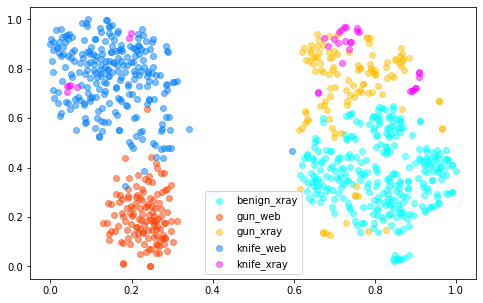

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



-----Epoch: 1/30-----
Train Classification Loss (E,C): 31.137  Train Domain Confusion Loss (E): 82.913  Valid Classification Loss (E,C): 8.144
Domain Classification Loss (D): 79.477  Domain Classification Accuracy (D): 0.652  elapsed time: 49.9s
--Source Domain Confusion Matrix:
[[ 45 188  18]
 [  1 127   1]
 [  8 139 100]]
--Target Domain Confusion Matrix:
[[ 74. 129. 125.]
 [ 34.  89.  38.]
 [ 11.  16.  20.]]

# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


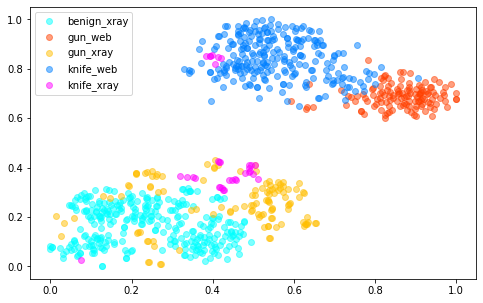

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



-----Epoch: 2/30-----
Train Classification Loss (E,C): 12.536  Train Domain Confusion Loss (E): 83.129  Valid Classification Loss (E,C): 12.440
Domain Classification Loss (D): 78.165  Domain Classification Accuracy (D): 0.807  elapsed time: 50.3s
--Source Domain Confusion Matrix:
[[175  66  10]
 [  7 121   1]
 [ 22  39 186]]
--Target Domain Confusion Matrix:
[[290.  22.  81.]
 [ 97.  78.  33.]
 [ 25.   7.  26.]]

# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


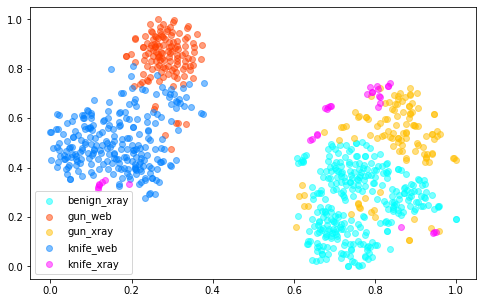

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



-----Epoch: 3/30-----
Train Classification Loss (E,C): 7.281  Train Domain Confusion Loss (E): 83.413  Valid Classification Loss (E,C): 15.236
Domain Classification Loss (D): 77.252  Domain Classification Accuracy (D): 0.832  elapsed time: 49.8s
--Source Domain Confusion Matrix:
[[218  22  11]
 [  9 117   3]
 [ 30  13 204]]
--Target Domain Confusion Matrix:
[[295.  21. 145.]
 [107.  79.  51.]
 [ 28.   4.  29.]]

# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


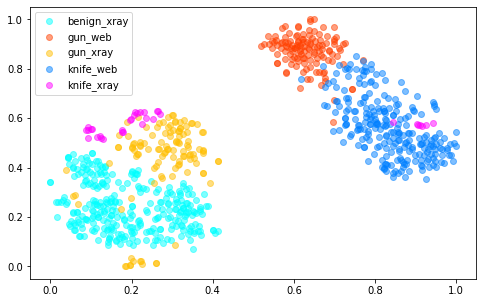

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



-----Epoch: 4/30-----
Train Classification Loss (E,C): 6.528  Train Domain Confusion Loss (E): 83.418  Valid Classification Loss (E,C): 17.699
Domain Classification Loss (D): 76.656  Domain Classification Accuracy (D): 0.823  elapsed time: 49.7s
--Source Domain Confusion Matrix:
[[233  10   8]
 [  8 118   3]
 [ 32   4 211]]
--Target Domain Confusion Matrix:
[[300.   6.  88.]
 [111.  64.  44.]
 [ 29.   1.  29.]]

# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


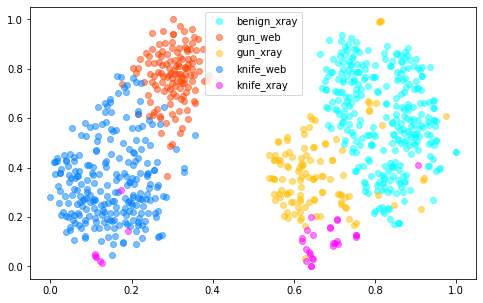

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



-----Epoch: 5/30-----
Train Classification Loss (E,C): 6.033  Train Domain Confusion Loss (E): 83.084  Valid Classification Loss (E,C): 20.027
Domain Classification Loss (D): 76.333  Domain Classification Accuracy (D): 0.804  elapsed time: 49.8s
--Source Domain Confusion Matrix:
[[231  10  10]
 [  6 118   5]
 [ 20   6 221]]
--Target Domain Confusion Matrix:
[[295.  20. 119.]
 [104.  84.  43.]
 [ 27.   3.  27.]]

# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


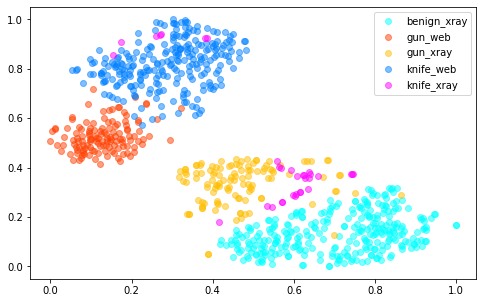

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



-----Epoch: 6/30-----
Train Classification Loss (E,C): 6.024  Train Domain Confusion Loss (E): 82.429  Valid Classification Loss (E,C): 22.344
Domain Classification Loss (D): 76.535  Domain Classification Accuracy (D): 0.747  elapsed time: 49.8s
--Source Domain Confusion Matrix:
[[239   7   5]
 [  7 118   4]
 [ 31   5 211]]
--Target Domain Confusion Matrix:
[[299.   9.  13.]
 [111.  78.  21.]
 [ 30.   1.  26.]]

# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


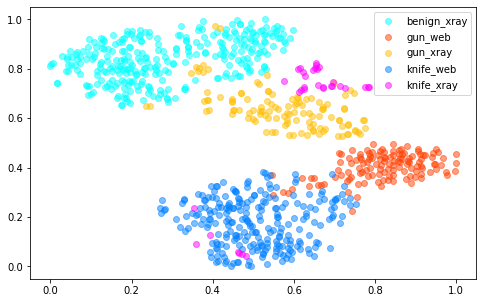

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



-----Epoch: 7/30-----
Train Classification Loss (E,C): 5.893  Train Domain Confusion Loss (E): 81.366  Valid Classification Loss (E,C): 24.360
Domain Classification Loss (D): 77.100  Domain Classification Accuracy (D): 0.686  elapsed time: 49.7s
--Source Domain Confusion Matrix:
[[229   8  14]
 [  5 118   6]
 [ 21   8 218]]
--Target Domain Confusion Matrix:
[[299.  13.  36.]
 [105.  95.  31.]
 [ 26.   2.  28.]]

# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


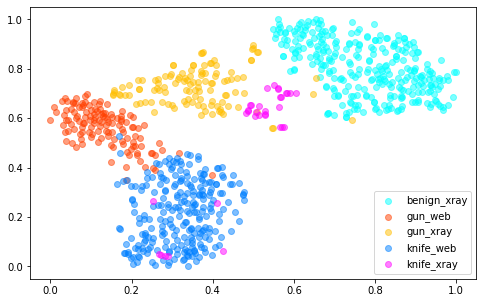

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



-----Epoch: 8/30-----
Train Classification Loss (E,C): 5.423  Train Domain Confusion Loss (E): 79.979  Valid Classification Loss (E,C): 26.353
Domain Classification Loss (D): 77.961  Domain Classification Accuracy (D): 0.630  elapsed time: 50.0s
--Source Domain Confusion Matrix:
[[239   4   8]
 [ 11 112   6]
 [ 26   1 220]]
--Target Domain Confusion Matrix:
[[300.   6.  11.]
 [111.  84.  29.]
 [ 28.   0.  26.]]

# of samples : 826 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


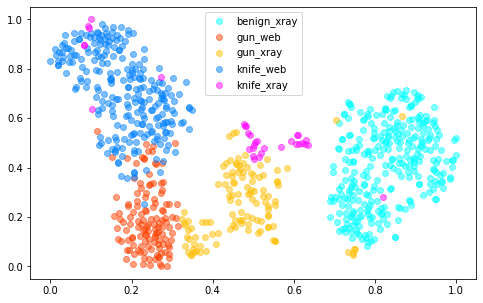

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: ignored

In [27]:
print("classes : {}".format(train_data_multi_label.classes))
encoder, classifier, classification_losses_E, domain_confusion_losses_E, losses_D, accs_D = train_adda(num_epochs = 30,
                                                                                                       lr = 2e-6,
                                                                                                       save_step = 5,
                                                                                                       encoder = encoder, 
                                                                                                       classifier = classifier,
                                                                                                       discriminator = discriminator,
                                                                                                       src_data_loaders = dataloaders_multi_label, 
                                                                                                       tgt_data_loader = xray_dataloader,
                                                                                                       tgt_data_loader_small = xray_test_dataloader,
                                                                                                       src_test_dir = "web_3cls+NOcutter/test", 
                                                                                                       tgt_test_dir = "Xray-3cls_small",
                                                                                                       combined_dataloader = combined_dataloader,
                                                                                                       alpha_CLS = 1.,
                                                                                                       alpha_DA = 1.5,
                                                                                                       multi_label = True,
                                                                                                       test_threshold=0.2)